Analyze Titles with Random Forests
==================================

This notebook will load titles data from the processed training set, and then convert the titles data into binary dummy variables.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import statistics as st
import numpy as np

import sklearn.metrics as ms
import sklearn.model_selection as mds
import sklearn.ensemble as en
import sklearn.tree as tr
import matplotlib.pyplot as plt

from scipy import interpolate

datestamp = "20250129.150949"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 21)


# Dummy Variables

 Get the dummy variables for the title and the gender data, to create new features. Move dummy variables into a new dataframe for analysis.

In [2]:
l_titles = [ 'Mr', 'Mrs', 'Miss', 'Master' ]

df_['TitleReduced'] = df_['Title']
df_['TitleReduced'] = df_['TitleReduced'].apply( lambda v: 'Other' if not v in l_titles else v )

df = pd.get_dummies(df_['TitleReduced'])
df["Survived"] = df_["Survived"]
df["Male"] = df_["SexOrd"]

In [3]:
df = df.map(lambda x: int(x))

x_colnames = l_titles + [ "Other" ]
y_colname = [ "Survived" ]

X = df[ x_colnames ]
y = df[ y_colname ].values.ravel()

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Mr      891 non-null    int64
 1   Mrs     891 non-null    int64
 2   Miss    891 non-null    int64
 3   Master  891 non-null    int64
 4   Other   891 non-null    int64
dtypes: int64(5)
memory usage: 34.9 KB
None


# Random Forest

Use a Random Forest classifier to analyze the features. Start by splitting the data into training and testing datasets

In [4]:
# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.5, random_state=42)

# Create a decision tree classifier
model = en.RandomForestClassifier( n_estimators=20,
                                   max_leaf_nodes=8,
                                   max_depth=6,
                                   random_state=42
                                 )

# Train the classifier
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_leaf_nodes=8, n_estimators=20,
                       random_state=42)

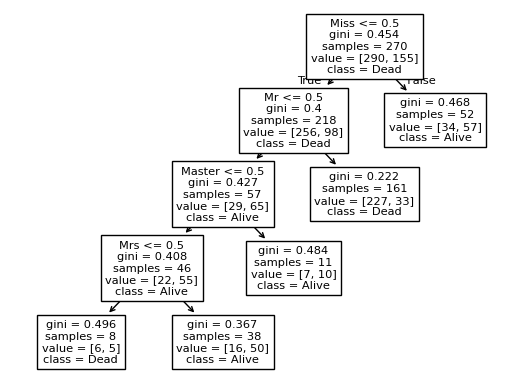

In [5]:
tr.plot_tree(model.estimators_[4], feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [6]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

  Feature  Gini Importance
0      Mr         0.693313
1     Mrs         0.167475
2    Miss         0.092905
3  Master         0.032536
4   Other         0.013771


In [7]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")



Test optimal threshold 0.532 at tpr: 0.777, fpr: 0.21


In [8]:
y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train optimal threshold: {train_threshold}")
print(f"{train_tpr_intrp(train_threshold)}, {train_fpr_intrp(train_threshold)}")
print()


Train optimal threshold: 0.5321972578437333
0.7484662576687117, 0.20212765957446807



In [9]:
# Define the desired operating point (FPR, TPR)
test_operating_point_fpr = test_fpr_intrp(test_threshold)
test_operating_point_tpr = test_tpr_intrp(test_threshold)

# Find the closest threshold to the desired operating point
distances = (test_fpr - test_operating_point_fpr)**2 + (test_tpr - test_operating_point_tpr)**2
closest_index = distances.argmin()
test_operating_point_threshold = test_thresh[closest_index]

In [10]:
# Define the desired operating point (FPR, TPR)
train_operating_point_fpr = train_fpr_intrp(train_threshold)
train_operating_point_tpr = train_tpr_intrp(train_threshold)

# Find the closest threshold to the desired operating point
distances = (train_fpr - train_operating_point_fpr)**2 + (train_tpr - train_operating_point_tpr)**2
closest_index = distances.argmin()
train_operating_point_threshold = train_thresh[closest_index]

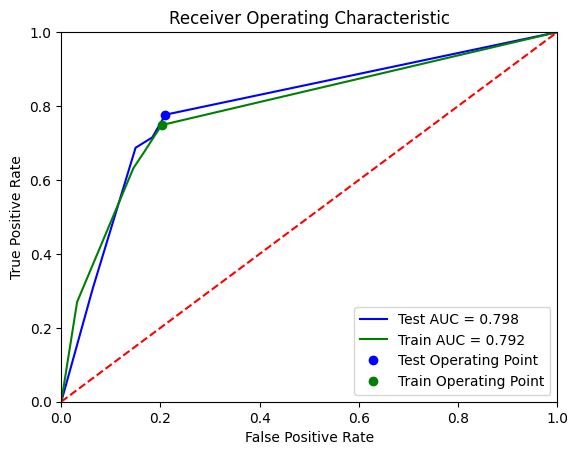

In [11]:
plt.title('Receiver Operating Characteristic')

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.plot(test_operating_point_fpr,test_operating_point_tpr, 'bo', label=f'Test Operating Point')
plt.plot(train_operating_point_fpr,train_operating_point_tpr, 'go', label=f'Train Operating Point')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()


In [12]:
y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {test_threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.532
  tn 218  fp 49 
  fn 51   tp 128

Bal Acc: 0.766, Pre: 0.723, Rec: 0.715, F1 Micro: 0.776
